# Mapping Residential Real Estate Prices in Latvia


This project analyses and visualises the average prices of flats and houses across different regions in Latvia for the year 2024.

**Parts:**
1. Data Processing
2. Regional Price Computation:
    1. Geographic Data Integration
    2. Visualisation on a Map
    3. Single Region Analysis


All the data used was available through Latvia's Open Data portal:
- Real estate transactions https://data.gov.lv/dati/lv/dataset/nekustama-ipasuma-tirgus-datu-bazes-atvertie-dati
- Latvia's regional borders https://data.gov.lv/dati/lv/dataset/varis-atvertie-dati
- Cadastral data: https://data.gov.lv/dati/lv/dataset/kadastra-informacijas-sistemas-atverti-telpiskie-dati


In [1]:
# load the libraries

import pandas as pd
import numpy as np
import geopandas

from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap

## 1. Process Transactions Data

Categorising transactions into two main property types: flats and houses, enabling separate visualisation for each category.

**Simplified assumptions.** Transactions might include land plots and additional structures or units along with a flat or a house. Since there is no consistent way to isolate the value of each component — and in some cases, the land may even be more valuable than the house itself — this project assumes the total transaction price represents the value of the house or flat only and excludes further breakdowns.

In [2]:
# even though the available data is split by year, 
# each year's data can also contain transactions from previous years

# download data 2024 and 2025 and list available CSV files for each year

zip_2024 = 'nitis_csv_2024.zip'
zip_2025 = 'nitis_csv_2025.zip'

with ZipFile(zip_2024, 'r') as archive:
    file_list_2024 = archive.namelist()
    
with ZipFile(zip_2025, 'r') as archive:
    file_list_2025 = archive.namelist()

    
print('Data for 2024:', file_list_2024)
print('Data for 2025:', file_list_2025)

Data for 2024: ['ZV_CSV_2024.csv', 'ZVB_CSV_2024.csv', 'TG_CSV_2024.csv']
Data for 2025: ['TG_CSV_2025.csv', 'ZV_CSV_2025.csv', 'ZVB_CSV_2025.csv']


In [3]:
# preview the data

with ZipFile(zip_2025, 'r') as archive:
    with archive.open('TG_CSV_2025.csv') as file:
        df = pd.read_csv(file, sep=';')
        

# change the default settings for max columns displayed
pd.set_option('display.max_columns', 45)     

df.head(3)

,Darījumu skaits atlasē,Darījuma ID,Objekts,Īpašuma kadastra numurs,Adreses pieraksts,Novads,Pilsēta,Pagasts,Darījuma datums,"Darījuma summa, EUR",Zemes vienību kadastra apzīmējumi(saraksts) (viena darījuma ietvaros),Zemes daļas(skaitītājs),Zemes daļas(saucējs),"Pārdotā zemes kopplatība, m2",NĪLM grupas kods (lielākais pēc platības),NĪLM kodi(saraksts),Būvju skaits,Būves kadastra apzīmējums,Būves daļas(skaitītājs),Būves daļas(saucējs),Būves lietošanas veida nosaukums,Būves lietošanas veida kods,Būves virszemes stāvu skaits,"Būves apbūves laukums, m2","Būves kopplatība, m2","Būves būvtilpums, m3",Būves ārsienu materiāla nosaukums,Būves ekspluatācijas uzsākšanas gads,"Būves fiziskais nolietojums, %",Būves kadastra apzīmējumu saraksts (viena darījuma ietvaros),Telpu grupu skaits (viena darījuma ietvaros),Dzīvokļu skaits (viena darījuma ietvaros),Telpu grupas kadastra apzīmējums,Telpu grupas daļas(skaitītājs),Telpu grupas daļas(saucējs),Telpu grupas lietošanas veida kods,Telpu grupas zemākais stāvs,Telpu grupas augstākais stāvs,"Telpu grupas platība, m2","Dzīvokļa kopplatība, m2",Telpu skaits telpu grupā,Istabu skaits dzīvoklī,Būves nolietojums
0,4815,1224922,Dz,1009231443,"Tomsona iela 23 - 9, Rīga, LV-1013",NaN,Rīga,NaN,04.12.2024,39999.0,01000240138,98.0,12029.0,9.12,7.0,"1001(38), 702(1049), 801(33)",1,1000240138001,98,12029,Triju vai vairāku dzīvokļu mājas,1122,5,975.7,4497.2,15835,"224 - Ķieģeļu mūris 1,5 līdz 2,5 ķieģeļu biezumā",1961.0,NaN,01000240138001,0,1,1000240138001009,1,1,1122,3,3,29.4,29.4,4,1,V3
1,4815,1224923,Dz,1009018915,"Tallinas iela 45 - 21, Rīga, LV-1012",NaN,Rīga,NaN,20.11.2024,47600.0,01000270047,467.0,25857.0,32.67,7.0,"1002(155), 601(274), 701(43), 702(940), 703(26...",7,1000270047001,467,25857,Triju vai vairāku dzīvokļu mājas,1122,5,440.0,1775.1,7931,"212 - Ķieģeļu mūris 2,5 ķieģeļu biezumā vai bi...",1908.0,NaN,"1000270047011, 1000270047010, 1000270047007, 1...",0,1,1000270047001021,1,1,1122,1,1,46.7,46.7,7,2,V3
2,4815,1224924,Dz,1009118906,"Andromedas gatve 8 - 38, Rīga, LV-1084",NaN,Rīga,NaN,06.12.2024,37500.0,01000712493,3811.0,311681.0,6.09,7.0,702(498),1,1000712276001,3811,311681,Triju vai vairāku dzīvokļu mājas,1122,5,821.6,4122.1,12667,223 - Dzelzsbetona paneļi,1975.0,NaN,01000712276001,0,1,1000712276001038,1,1,1122,3,3,38.1,38.1,7,2,V3


*Cadastral codes are read as integers and therefore miss leading zeros.*

### Process Data for Flats

In [4]:
# load data


# specify list of columns to use
columns = ['Darījuma ID', 
           'Darījuma datums', 
           'Objekts', 
           'Būves kadastra apzīmējums', 
           'Darījuma summa, EUR', 
           'Dzīvokļa kopplatība, m2', 
           'Novads', 
           'Pilsēta', 
           'Pagasts']


# for 2024
with ZipFile(zip_2024, 'r') as archive:
    with archive.open('TG_CSV_2024.csv') as file:
        tg1 = pd.read_csv(file, 
                          sep=';', 
                          dtype={'Būves kadastra apzīmējums': 'str'}, 
                          usecols=columns)

# for 2025
with ZipFile(zip_2025, 'r') as archive:
    with archive.open('TG_CSV_2025.csv') as file:
        tg2 = pd.read_csv(file, 
                          sep=';', 
                          dtype={'Būves kadastra apzīmējums': 'str'}, 
                          usecols=columns)
        

# combine into a single dataframe
tg = pd.concat([tg1, tg2], ignore_index=True)


# check data types
tg.dtypes

Darījuma ID                    int64
Objekts                       object
Novads                        object
Pilsēta                       object
Pagasts                       object
Darījuma datums               object
Darījuma summa, EUR          float64
Būves kadastra apzīmējums     object
Dzīvokļa kopplatība, m2      float64
dtype: object

In [5]:
# convert date column to datetime
tg['Darījuma datums'] = pd.to_datetime(tg['Darījuma datums'], dayfirst=True)

# convert transaction amounts to integer
tg['Darījuma summa, EUR'] = tg['Darījuma summa, EUR'].astype(int)

In [6]:
# filter flats sold in 2024
flats = tg.loc[(tg['Objekts'] == 'Dz') & 
            (tg['Darījuma datums'].astype('str').str[:4] == '2024')]



# since the dataset spans two years, end-of-year transactions might overlap with the next year
# drop any possible duplicate transactions & unnessasaty columns
flats = (flats
         .drop_duplicates(subset=['Darījuma ID', 'Būves kadastra apzīmējums', 'Darījuma summa, EUR'])
         .drop(columns=['Objekts', 'Darījuma datums'])
         .reset_index(drop=True))

# keep only nessasary columns
flats = flats[['Darījuma ID', 
               'Būves kadastra apzīmējums', 
               'Darījuma summa, EUR', 
               'Dzīvokļa kopplatība, m2', 
               'Novads', 
               'Pilsēta', 
               'Pagasts']]

flats.head(3)

,Darījuma ID,Būves kadastra apzīmējums,"Darījuma summa, EUR","Dzīvokļa kopplatība, m2",Novads,Pilsēta,Pagasts
0,1173041,44070030064001,22000,69.1,Augšdaugavas nov.,Ilūkste,NaN
1,1173045,01001212144002,28900,33.0,NaN,Rīga,NaN
2,1173048,17000440082001,5800,14.6,NaN,Liepāja,NaN


### Calculate Flat Price per Square Metre

In Latvia, flats are not typically categorised by the number of bedrooms, making direct comparisons based on unit type less meaningful. Therefore, for consistency and comparability, flat prices in this project are analysed per square metre rather than using the total price of each flat.

<Axes: xlabel='Dzīvokļa kopplatība, m2', ylabel='Count'>

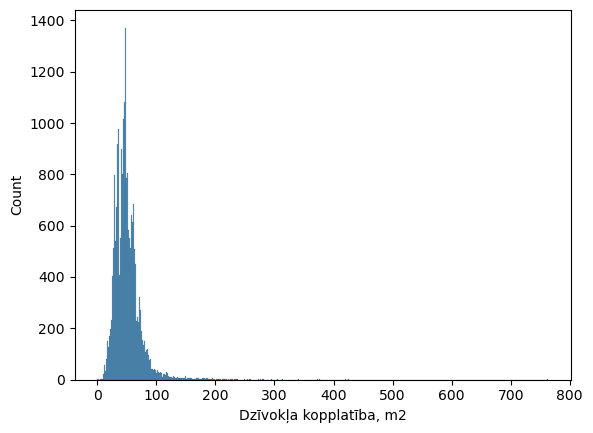

In [7]:
# look at the distribution of flat sizes
sns.histplot(flats, x='Dzīvokļa kopplatība, m2')

*Flat sizes are highly skewed and need to be normalised*

<Axes: xlabel='Dzīvokļa kopplatība, m2', ylabel='Count'>

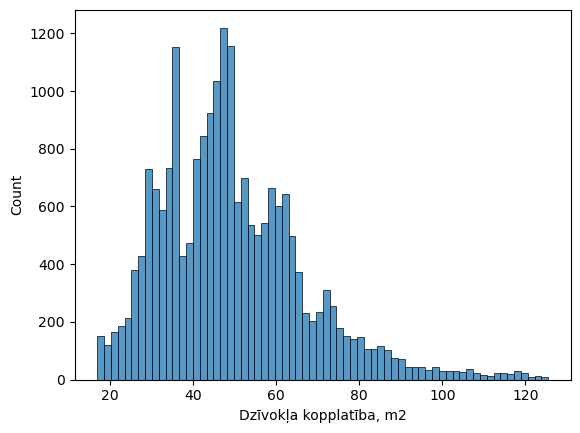

In [8]:
# apply a log transformation method in order to normalise flat sizes

# use 'log1p' to handle zero values safely
flats['log_sqm'] = np.log1p(flats['Dzīvokļa kopplatība, m2'])

# detect outliners using the IQR method
Q1 = flats['log_sqm'].quantile(0.25)
Q3 = flats['log_sqm'].quantile(0.75)
IQR = Q3 - Q1

# define bounds for outliners
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter out outliers from the dataset
flats = (flats
         .loc[(flats['log_sqm'] >= lower_bound) & (flats['log_sqm'] <= upper_bound)]
         .drop(columns=['log_sqm']))


# check the distribution again
sns.histplot(flats, x='Dzīvokļa kopplatība, m2')

In [9]:
# calculate price per square metre
flats['Kvm_cena'] = (flats['Darījuma summa, EUR'] / flats['Dzīvokļa kopplatība, m2']).round(2)

# keep only nessasary columns
flats = (flats
         .drop(columns=['Darījuma summa, EUR', 'Dzīvokļa kopplatība, m2'])
         .sort_values('Kvm_cena')
         .reset_index(drop=True))

flats.head(3)

,Darījuma ID,Būves kadastra apzīmējums,Novads,Pilsēta,Pagasts,Kvm_cena
0,1207378,01000252015001,NaN,Rīga,NaN,0.01
1,1227684,96920030155001,Valmieras nov.,NaN,Vecates pag.,0.16
2,1198515,01000782081001,NaN,Rīga,NaN,0.22


### Process Data for Houses

In [10]:
# load data


# specify list of columns to use
columns = ['Darījuma ID', 
           'Darījuma datums', 
           'Būves lietošanas veida kods', 
           'Būves kadastra apzīmējums', 
           'Darījuma summa, EUR', 
           'Novads', 
           'Pilsēta', 
           'Pagasts']


# for 2024
with ZipFile(zip_2024, 'r') as archive:
    with archive.open('ZVB_CSV_2024.csv') as file:
        zvb1 = pd.read_csv(file, 
                           sep=';', 
                           dtype={'Būves kadastra apzīmējums': 'str'}, 
                           usecols=columns)

# for 2025
with ZipFile(zip_2025, 'r') as archive:
    with archive.open('ZVB_CSV_2025.csv') as file:
        zvb2 = pd.read_csv(file, 
                           sep=';', 
                           dtype={'Būves kadastra apzīmējums': 'str'}, 
                           usecols=columns)
        

# combine into a single dataframe
zvb = pd.concat([zvb1, zvb2], ignore_index=True)


# check data types
zvb.dtypes

Darījuma ID                      int64
Novads                          object
Pilsēta                         object
Pagasts                         object
Darījuma datums                 object
Darījuma summa, EUR            float64
Būves kadastra apzīmējums       object
Būves lietošanas veida kods    float64
dtype: object

In [11]:
# convert data types

zvb['Darījuma datums'] = pd.to_datetime(zvb['Darījuma datums'], dayfirst=True)
zvb['Darījuma summa, EUR'] = zvb['Darījuma summa, EUR'].astype(int)

In [12]:
# filter houses sold in 2024
# codes starting with '111' are single-family residential houses: 
# source: https://likumi.lv/ta/id/299645-buvju-klasifikacijas-noteikumi#piel0

houses = zvb.loc[(zvb['Būves lietošanas veida kods'].astype('str').str[:3] == '111') & 
                 (zvb['Darījuma datums'].astype('str').str[:4] == '2024')]


# drop duplicates & unnessasaty columns
houses = (houses
          .drop_duplicates(subset=['Darījuma ID', 'Būves kadastra apzīmējums', 'Darījuma summa, EUR'])
          .drop(columns=['Būves lietošanas veida kods', 'Darījuma datums'])
          .reset_index(drop=True))


houses.head(3)

,Darījuma ID,Novads,Pilsēta,Pagasts,"Darījuma summa, EUR",Būves kadastra apzīmējums
0,1173061,NaN,Rēzekne,NaN,8000,21000091504001
1,1173191,Ludzas nov.,NaN,Istras pag.,15750,68600030056001
2,1173200,NaN,Rīga,NaN,37000,01000430049003


## 2. Regional Price Computation

Latvia’s administrative division consists of municipalities (that further split into parishes) and a few state cities. This project focuses on smaller territorial units: parishes, cities, and towns. For each region, the average price is calculated only if there were 3 or more transactions, ensuring statistical relevance.

### Process Spacial Data for Regions

In [13]:
# download region borders

aw_shp = 'aw_shp.zip'

with ZipFile(aw_shp, 'r') as archive:
    # listing all files inside the ZIP
    file_list = archive.namelist()


# preview file structure, looking for Shapefiles for parishes and cities/towns
file_list

['Adm_rob.cpg',
 'Adm_rob.dbf',
 'Adm_rob.prj',
 'Adm_rob.shp',
 'Adm_rob.shx',
 'Autoceli.cpg',
 'Autoceli.dbf',
 'Autoceli.prj',
 'Autoceli.shp',
 'Autoceli.shx',
 'Ciemi.cpg',
 'Ciemi.dbf',
 'Ciemi.prj',
 'Ciemi.shp',
 'Ciemi.shx',
 'Ekas.cpg',
 'Ekas.dbf',
 'Ekas.prj',
 'Ekas.shp',
 'Ekas.shx',
 'Ielas.cpg',
 'Ielas.dbf',
 'Ielas.prj',
 'Ielas.shp',
 'Ielas.shx',
 'Mazciemi.cpg',
 'Mazciemi.dbf',
 'Mazciemi.prj',
 'Mazciemi.shp',
 'Mazciemi.shx',
 'Novadi.cpg',
 'Novadi.dbf',
 'Novadi.prj',
 'Novadi.shp',
 'Novadi.shx',
 'Pagasti.cpg',
 'Pagasti.dbf',
 'Pagasti.prj',
 'Pagasti.shp',
 'Pagasti.shx',
 'Pilsetas.cpg',
 'Pilsetas.dbf',
 'Pilsetas.prj',
 'Pilsetas.shp',
 'Pilsetas.shx']

In [30]:
# load parishes
parishes = geopandas.read_file(f'zip://{aw_shp}!{'Pagasti.shp'}')

# load cities/towns
towns = geopandas.read_file(f'zip://{aw_shp}!{'Pilsetas.shp'}')

In [15]:
# inspect columns for parishes
parishes.head(1)

,KODS,TIPS_CD,NOSAUKUMS,VKUR_CD,VKUR_TIPS,APSTIPR,APST_PAK,STATUSS,SORT_NOS,DAT_SAK,DAT_MOD,DAT_BEIG,ATRIB,STD,geometry
0,100010226,105,Annas pag.,100015694,113,Y,252,EKS,Annas pagasts,1999.03.16,30.06.2021 07:12:32,None,0021410,"Annas pag., Alūksnes nov.","POLYGON ((677778.673 359544.452, 677796.232 35..."


In [16]:
# and for cities/towns
towns.head(1)

,KODS,TIPS_CD,NOSAUKUMS,VKUR_CD,VKUR_TIPS,APSTIPR,APST_PAK,STATUSS,SORT_NOS,DAT_SAK,DAT_MOD,DAT_BEIG,ATRIB,STD,geometry
0,100003003,104,Rīga,100000000,101,Y,252,EKS,Rīga,1999.03.16,11.04.2024 12:16:05,None,0001000,Rīga,"POLYGON ((514051.994 306069.253, 513976.965 30..."


In [17]:
# because some parishes have duplicate names, 
# use the full name from the 'STD' column to ensure uniqueness
parishes.loc[parishes['NOSAUKUMS'].duplicated(keep=False)]

,KODS,TIPS_CD,NOSAUKUMS,VKUR_CD,VKUR_TIPS,APSTIPR,APST_PAK,STATUSS,SORT_NOS,DAT_SAK,DAT_MOD,DAT_BEIG,ATRIB,STD,geometry
38,100010113,105,Pilskalnes pag.,100016630,113,Y,252,EKS,Pilskalnes pagasts,1999.03.16,03.08.2022 00:00:00,None,0020500,"Pilskalnes pag., Aizkraukles nov.","POLYGON ((576108.025 234015.920, 576112.143 23..."
109,100014877,105,Salas pag.,100016421,113,Y,252,EKS,Salas pagasts,1999.03.16,30.06.2021 05:32:32,None,0031550,"Salas pag., Jēkabpils nov.","POLYGON ((612730.577 262627.399, 612707.536 26..."
352,100011076,105,Pilskalnes pag.,100016462,113,Y,252,EKS,Pilskalnes pagasts,1999.03.16,30.06.2021 06:12:17,None,0022550,"Pilskalnes pag., Augšdaugavas nov.","POLYGON ((639774.607 202538.172, 639757.420 20..."
386,100013705,105,Salas pag.,100016583,113,Y,252,EKS,Salas pagasts,1999.03.16,30.06.2021 06:40:46,None,0039420,"Salas pag., Mārupes nov.","POLYGON ((481262.272 303239.716, 480998.751 30..."


In [18]:
# drop unnessasary columns
parishes = parishes[['STD', 'geometry']]
towns = towns[['STD', 'geometry']]

# combine into a single GeoDataFrame
regions = geopandas.GeoDataFrame(pd.concat([parishes, towns], ignore_index=True))

# transform geometries to WGS84 for mapping
regions = regions.to_crs(4326)

# rename column
regions = regions.rename(columns={'STD': 'Regions'})

regions.head(3)

,Regions,geometry
0,"Annas pag., Alūksnes nov.","POLYGON ((26.95436 57.34404, 26.95467 57.34428..."
1,"Svētes pag., Jelgavas nov.","POLYGON ((23.60007 56.49703, 23.59865 56.49750..."
2,"Zvirgzdenes pag., Ludzas nov.","POLYGON ((27.62710 56.57246, 27.62709 56.57240..."


### Calculate and Display on a Map: Average Price per Region

In [19]:
# match region name structure from the 'regions' dataset
# format: parish + municipality, and for state cities just the city name

flats = flats.assign(Regions=flats['Pilsēta'].fillna(flats['Pagasts'] + ', ' + flats['Novads']))
flats.loc[(flats['Pilsēta'].notna() & flats['Novads'].notna()), 'Regions'] = flats['Pilsēta'] + ', ' + flats['Novads']


houses = houses.assign(Regions=houses['Pilsēta'].fillna(houses['Pagasts'] + ', ' + houses['Novads']))
houses.loc[(houses['Pilsēta'].notna() & houses['Novads'].notna()), 'Regions'] = houses['Pilsēta'] + ', ' + houses['Novads']

flats.head(3)

,Darījuma ID,Būves kadastra apzīmējums,Novads,Pilsēta,Pagasts,Kvm_cena,Regions
0,1207378,01000252015001,NaN,Rīga,NaN,0.01,Rīga
1,1227684,96920030155001,Valmieras nov.,NaN,Vecates pag.,0.16,"Vecates pag., Valmieras nov."
2,1198515,01000782081001,NaN,Rīga,NaN,0.22,Rīga


In [20]:
# FLATS

# canculate average price per region
flats_region_avg = (flats
                    .groupby(by='Regions')
                    .agg(Vidējā_kvm_cena=('Kvm_cena', 'mean'), Darījumu_skaits=('Būves kadastra apzīmējums', 'count'))
                    .reset_index())


# add spatial data by joining on region name
# keep geometries for all regions to display regions with fewer than 3 transactions (or NA values)
flats_region_avg = regions.merge(flats_region_avg
                                 .loc[flats_region_avg['Darījumu_skaits'] >= 3], how='left', on='Regions')

# round for clarity
flats_region_avg['Vidējā_kvm_cena'] = flats_region_avg['Vidējā_kvm_cena'].round(2)
flats_region_avg['Darījumu_skaits'] = flats_region_avg['Darījumu_skaits'].astype('Int64')


# top 10 regions with the most expensive flats per sqm in 2024
# based on 3 or more transactions per region
flats_region_avg.sort_values('Vidējā_kvm_cena', ascending=False).head(10)

,Regions,geometry,Vidējā_kvm_cena,Darījumu_skaits
520,"Mārupe, Mārupes nov.","POLYGON ((24.04862 56.91233, 24.04906 56.91229...",2012.70,134
55,"Engures pag., Tukuma nov.","POLYGON ((23.14910 57.12927, 23.14875 57.12915...",1968.97,34
258,"Babītes pag., Mārupes nov.","POLYGON ((23.96323 56.95070, 23.96153 56.95009...",1767.86,67
451,"Stopiņu pag., Ropažu nov.","POLYGON ((24.29383 56.92062, 24.29297 56.92070...",1639.92,130
533,"Baloži, Ķekavas nov.","POLYGON ((24.14542 56.88374, 24.14542 56.88377...",1421.48,93
586,"Ādaži, Ādažu nov.","POLYGON ((24.32010 57.06871, 24.31986 57.06950...",1356.20,83
511,Rīga,"POLYGON ((24.23069 56.89812, 24.22945 56.89739...",1283.56,10036
400,"Ķekavas pag., Ķekavas nov.","MULTIPOLYGON (((24.15150 56.90913, 24.15162 56...",1229.76,42
263,"Ozolnieku pag., Jelgavas nov.","POLYGON ((23.76379 56.68717, 23.76338 56.68725...",1228.17,58
587,"Saulkrasti, Saulkrastu nov.","POLYGON ((24.42842 57.24865, 24.42754 57.24855...",1206.59,26


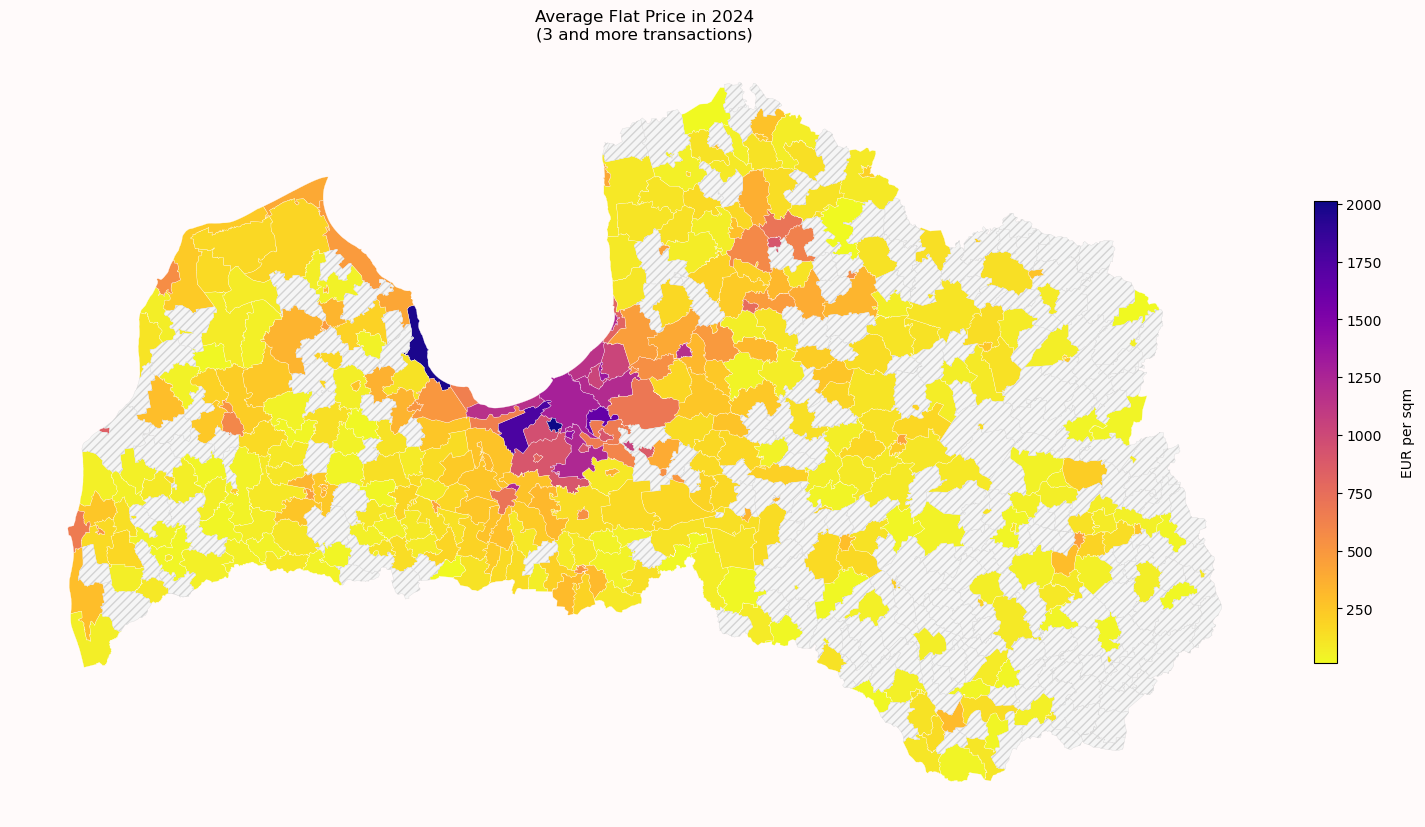

In [21]:
# Choropleth map for average flat prices

fig, ax = plt.subplots(figsize=(22,10), facecolor = 'Snow')

flats_region_avg.plot(
    column='Vidējā_kvm_cena', 
    cmap='plasma_r', 
    ax=ax, 
    linewidth=0.2,
    edgecolor="white",
    missing_kwds={
        "color": "WhiteSmoke",
        #"edgecolor": "WhiteSmoke", 
        "edgecolor": "LightGrey", 
        "hatch": "////",
    },
)

cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6, aspect=20, pad=0.02)
cbar.set_label('EUR per sqm', labelpad=14)

ax.axis('off')
plt.title('Average Flat Price in 2024\n(3 and more transactions)')

plt.show()

In [22]:
# HOUSES

# canculate average price per region
houses_region_avg = (houses
                     .groupby(by='Regions')
                     .agg(Vidējā_cena=('Darījuma summa, EUR', 'mean'), Darījumu_skaits=('Darījuma ID', 'count'))
                     .reset_index())


# add spatial data & keep geometries for empty regions same as for flats
houses_region_avg = regions.merge(houses_region_avg
                                  .loc[houses_region_avg['Darījumu_skaits'] >= 3], how='left', on='Regions')

# round for clarity
houses_region_avg['Vidējā_cena'] = houses_region_avg['Vidējā_cena'].round(0).astype('Int64')
houses_region_avg['Darījumu_skaits'] = houses_region_avg['Darījumu_skaits'].astype('Int64')


# top 10 regions with the most expensive houses in 2024
# based on 3 or more transactions per region
houses_region_avg.sort_values('Vidējā_cena', ascending=False).head(10)

,Regions,geometry,Vidējā_cena,Darījumu_skaits
467,"Raiskuma pag., Cēsu nov.","POLYGON ((25.11105 57.41366, 25.11585 57.41383...",312452,3
386,"Salas pag., Mārupes nov.","POLYGON ((23.69260 56.87254, 23.68828 56.87256...",296372,8
454,"Mārupes pag., Mārupes nov.","POLYGON ((23.99020 56.90792, 23.99096 56.90709...",270434,22
258,"Babītes pag., Mārupes nov.","POLYGON ((23.96323 56.95070, 23.96153 56.95009...",257697,81
373,"Bērzes pag., Dobeles nov.","POLYGON ((23.30242 56.64997, 23.30953 56.65243...",248800,5
79,"Ādažu pag., Ādažu nov.","POLYGON ((24.36174 57.06076, 24.36167 57.06068...",244187,30
520,"Mārupe, Mārupes nov.","POLYGON ((24.04862 56.91233, 24.04906 56.91229...",238070,63
519,Jūrmala,"POLYGON ((23.54937 56.97847, 23.54939 56.97847...",220453,288
552,"Ķekava, Ķekavas nov.","POLYGON ((24.24906 56.82487, 24.25005 56.82486...",191857,14
575,"Sigulda, Siguldas nov.","POLYGON ((24.80174 57.15598, 24.80183 57.15594...",182152,42


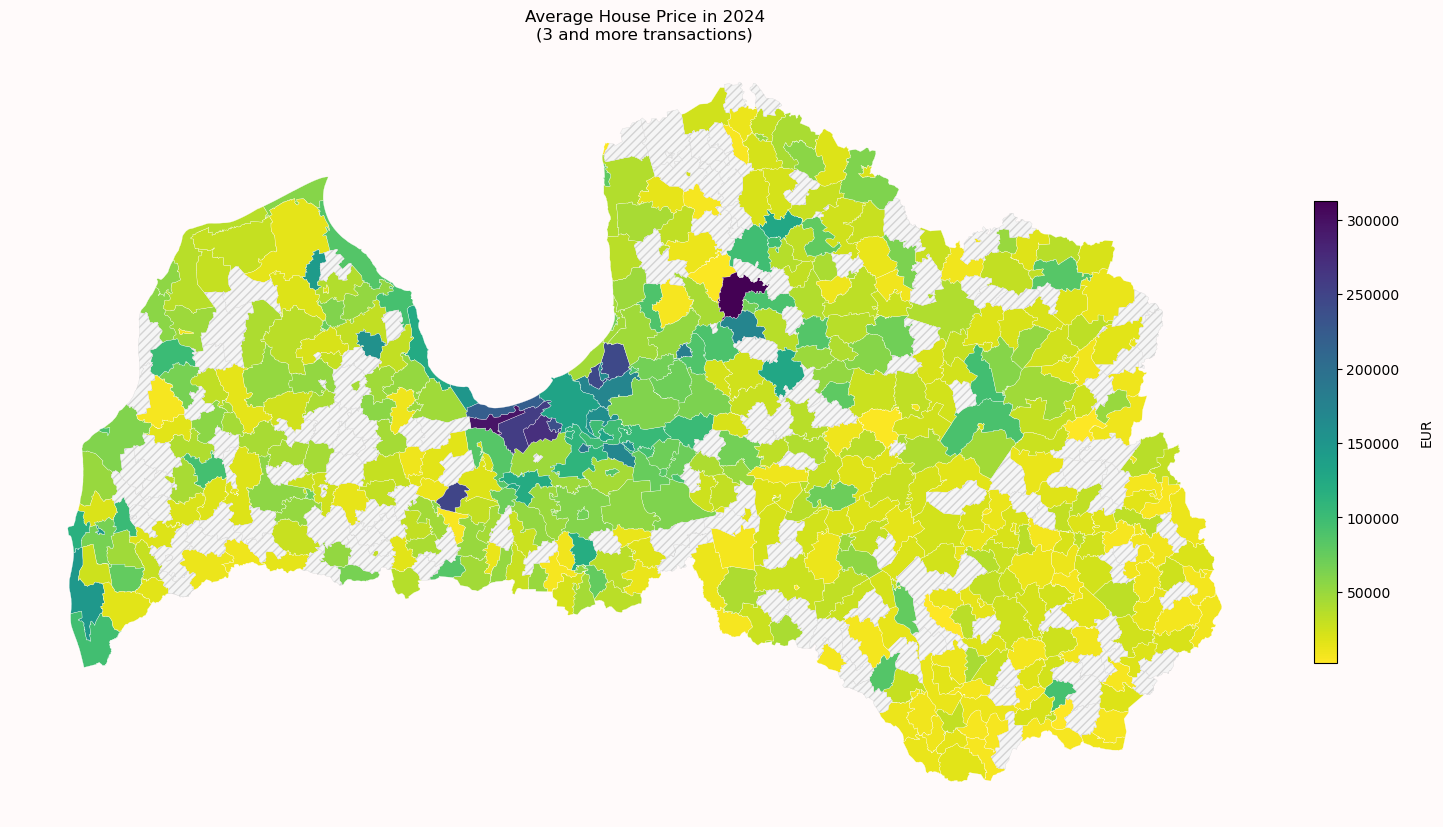

In [23]:
# Choropleth map for average house prices

fig, ax = plt.subplots(figsize=(22,10), facecolor = 'Snow')

houses_region_avg.plot(
    column='Vidējā_cena', 
    #cmap='GnBu', 
    cmap='viridis_r', 
    ax=ax, 
    linewidth=0.2,
    edgecolor="white",
    missing_kwds={
        "color": "WhiteSmoke",
        "edgecolor": "LightGrey", 
        "hatch": "////",
    },
)

cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6, aspect=20, pad=0.02)
cbar.set_label('EUR', labelpad=14)

ax.axis('off')
plt.title('Average House Price in 2024\n(3 and more transactions)')

plt.show()

In [24]:
# list regions where houses were sold for 1 million EUR or more

million_houses = (houses
                  .loc[houses['Darījuma summa, EUR'] >= 1000000]
                  .groupby(by='Regions')['Darījuma summa, EUR']
                  .count()
                  .reset_index()
                  .sort_values('Darījuma summa, EUR', ascending=False)
                  .reset_index(drop=True))

million_houses = million_houses.rename(columns={'Darījuma summa, EUR': 'Darījumu_skaits'})
million_houses

,Regions,Darījumu_skaits
0,Jūrmala,12
1,Rīga,2
2,"Babītes pag., Mārupes nov.",1
3,"Mārupes pag., Mārupes nov.",1
4,"Nīcas pag., Dienvidkurzemes nov.",1
5,"Ādažu pag., Ādažu nov.",1


## Single Region Analysis: Heatmap for Sigulda Municipality

Cadastral spatial data for Latvia is split into multiple regional ZIP archives. Therefore, for creating a heatmap of individual transactions, this project focuses on a single region.

### Import and Process Cadastral Data

In [25]:
# download cadastral data for Sigulda municipality
zip_file = '0048000_kk_shp.zip'

with ZipFile(zip_file, 'r') as archive:
    # listing all files inside the ZIP
    file_list = archive.namelist()


# preview structure
file_list[:50]

['CadGroups_AT_0048000/',
 'CadGroups_AT_0048000/KKCadastralGroup.cpg',
 'CadGroups_AT_0048000/KKCadastralGroup.dbf',
 'CadGroups_AT_0048000/KKCadastralGroup.prj',
 'CadGroups_AT_0048000/KKCadastralGroup.shp',
 'CadGroups_AT_0048000/KKCadastralGroup.shx',
 'ExportCadGroup_4266001/',
 'ExportCadGroup_4266001/KKBuilding.cpg',
 'ExportCadGroup_4266001/KKBuilding.dbf',
 'ExportCadGroup_4266001/KKBuilding.prj',
 'ExportCadGroup_4266001/KKBuilding.shp',
 'ExportCadGroup_4266001/KKBuilding.shx',
 'ExportCadGroup_4266001/KKEngineeringStructurePoly.cpg',
 'ExportCadGroup_4266001/KKEngineeringStructurePoly.dbf',
 'ExportCadGroup_4266001/KKEngineeringStructurePoly.prj',
 'ExportCadGroup_4266001/KKEngineeringStructurePoly.shp',
 'ExportCadGroup_4266001/KKEngineeringStructurePoly.shx',
 'ExportCadGroup_4266001/KKParcel.cpg',
 'ExportCadGroup_4266001/KKParcel.dbf',
 'ExportCadGroup_4266001/KKParcel.prj',
 'ExportCadGroup_4266001/KKParcel.shp',
 'ExportCadGroup_4266001/KKParcel.shx',
 'ExportCadGroup

*The data is split into subfolders for each cadastral group, each containing multiple Shapefiles*

In [26]:
# load data for building

with ZipFile(zip_file, 'r') as archive:
    # identify folders starting with 'ExportCadGroup_' that contain ShapeFiles for building
    shp_buildings = [f for f in file_list if f.startswith('ExportCadGroup_') and f.endswith('KKBuilding.shp')]
    
    # read each ShapeFile and store in a list
    gdfs = [geopandas.read_file(f'zip://{zip_file}!{buildings}') for buildings in shp_buildings]
    

# combine all GeoDataFrames
sig = geopandas.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

sig.head(3)

,CODE,OBJECTCODE,PARCELCODE,AREA_SCALE,GROUP_CODE,geometry
0,42660010025005,5201011310,42660010186,38.877388,4266001,"POLYGON ((562391.045 329300.490, 562397.089 32..."
1,42660010021002,5201011110,42660010021,37.116147,4266001,"POLYGON ((562428.655 328208.890, 562434.557 32..."
2,42660010025001,5201011110,42660010186,224.167917,4266001,"POLYGON ((562345.756 329259.381, 562340.467 32..."


In [27]:
# drop unnessasary columns
sig = sig.drop(columns=['OBJECTCODE', 'PARCELCODE', 'AREA_SCALE', 'GROUP_CODE'])

# create geometric centroids for each building to use in a heatmap
sig['geometry'] = sig.centroid

# transform geometries to WGS84
sig = sig.to_crs(4326)

sig.head(3)

,CODE,geometry
0,42660010025005,POINT (25.02996 57.10277)
1,42660010021002,POINT (25.03031 57.09297)
2,42660010025001,POINT (25.02927 57.10253)


### Create Heatmap for Flat and House Prices in Sigulda Municipality

In [28]:
# join each transaction with the building's centroid using the building's cadastral code
flats_sig = flats.merge(sig, how='inner', left_on='Būves kadastra apzīmējums', right_on='CODE')
houses_sig = houses.merge(sig, how='inner', left_on='Būves kadastra apzīmējums', right_on='CODE')

# convert to GeoDataFrame
flats_sig = geopandas.GeoDataFrame(flats_sig, geometry=flats_sig['geometry'])
houses_sig = geopandas.GeoDataFrame(houses_sig, geometry=houses_sig['geometry'])

print('flats:', flats_sig.shape)
print('houses:', houses_sig.shape)

flats: (240, 9)
houses: (151, 9)


In [29]:
# MAP FLATS

# convert to list of [lat, lon, weight]
heat_data = [[point.y, point.x, price] for point, price in zip(flats_sig['geometry'], flats_sig['Kvm_cena'])]

# create Folium map centred on a region
map_flats = folium.Map(location=[flats_sig['geometry'].y.mean(), flats_sig['geometry'].x.mean()], 
               tiles="cartodb positron", 
               zoom_start=10)

# add heatmap layer
HeatMap(heat_data, radius=15, blur=10).add_to(map_flats)


### ### ###

# MAP HOUSES

# convert to list of [lat, lon, weight]
heat_data = [[point.y, point.x, price] for point, price in zip(houses_sig['geometry'], houses_sig['Darījuma summa, EUR'])]

# create Folium map centred on a region
map_houses = folium.Map(location=[houses_sig['geometry'].y.mean(), houses_sig['geometry'].x.mean()], 
               tiles="cartodb positron", 
               zoom_start=10)

# add heatmap layer
HeatMap(heat_data, radius=15, blur=10).add_to(map_houses)


<p>GitHub does not render interactive JavaScript outputs (like Folium maps) in static notebook previews. Therefore, screenshots of the maps are included for reference. To explore the interactive maps, please click on the titles or the images below.</p>

<div style="display: flex; justify-content: center; align-items: flex-start; margin-top: 20px;">

  <div style="text-align: center;">
    <a href="https://iliberts.github.io/projects/Mapping%20Residential%20Real%20Estate%20Prices/Sigulda_Municipality_Flat_Prices_2024_Heatmap.html" target="_blank" style="text-decoration: none; color: inherit;">
      <div><strong>Flats:</strong></div>
      <img src="Sigulda_Municipality_Flat_Prices_2024_Heatmap.png" alt="map_flats" width="440">
    </a>
  </div>

  <div style="text-align: center; margin-left: 10px">
    <a href="https://iliberts.github.io/projects/Mapping%20Residential%20Real%20Estate%20Prices/Sigulda_Municipality_House_Prices_2024_Heatmap.html" target="_blank" style="text-decoration: none; color: inherit;">
      <div><strong>Houses:</strong></div>
      <img src="Sigulda_Municipality_House_Prices_2024_Heatmap.png" alt="map_houses" width="440">
    </a>
  </div>

</div>


### Summary
This project provides a structured approach to analysing residential real estate prices in Latvia for 2024 by processing transaction and cadastral data, calculating average prices per region, and visualising the results using maps. While simplifications were made, the results still offer meaningful insights into spatial patterns.